In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import itertools

import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from replay.session_handler import State

from simulator.modules import SDVDataGenerator, evaluate_synthetic
from simulator.utils import pandas_to_spark

from datautils import *

%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

SPARK_LOCAL_DIR = '../tmp'
MOVIELENS_DATA_PATH = r'file:///home/anthony/codin/sber/data/Movielens'
NETFLIX_DATA_PATH   = r'file:///home/anthony/codin/sber/data/Netflix'
AMAZON_DATA_PATH    = r'file:///home/anthony/codin/sber/data/Amazon'

spark = SparkSession.builder\
    .appName('simulator_items')\
    .master('local[8]')\
    .config('spark.sql.shuffle.partitions', '8')\
    .config('spark.default.parallelism', '8')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '24g')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)

22/11/07 03:55:22 WARN Utils: Your hostname, anthony resolves to a loopback address: 127.0.1.1; using 192.168.88.228 instead (on interface enp3s0)
22/11/07 03:55:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/11/07 03:55:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/07 03:55:22 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [33]:
NUM_TEST_SAMPLES = 2000

def test_baseline(df):
    means = df.toPandas().mean().values
    stds = df.toPandas().std().values
    cov_m = np.diag(stds)

    real_df = df.sample(NUM_TEST_SAMPLES / df.count())
    rand_arr = np.random.multivariate_normal(means, cov_m, real_df.count())
    synth_df = pd.DataFrame(data=rand_arr, columns=df.columns)
    synth_df = pandas_to_spark(synth_df, spark_session=spark)

    metrics = evaluate_synthetic(synth_df, real_df)

    result = pd.DataFrame(index=np.arange(4))
    result['Model_name'] = 'Baseline'
    result['Metric_score'] = [v for k, v in metrics.items()]
    result['Metric_name'] = [k for k, v in metrics.items()]

    return result

def test_gen(generator, items_df):
    generator.setDevice('cuda:0')

    print(f'Training {generator._model_name} generator')
    start = time.time()
    generator.fit(items_df.sample(10000 / items_df.count()))
    fit_time = time.time() - start
    
    generator.setDevice('cpu')

    print(f'Evaluating {generator._model_name} generator')
    real_df = items_df.sample(NUM_TEST_SAMPLES / items_df.count())
    synth_df = generator.generate(real_df.count()).drop(generator._id_col_name)

    metrics = evaluate_synthetic(synth_df, real_df)

    result = pd.DataFrame(index=np.arange(4))
    result['Model_name'] = generator._model_name
    result['Metric_score'] = [v for k, v in metrics.items()]
    result['Metric_name'] = [k for k, v in metrics.items()]

    return fit_time, generator, result

def create_hist_values(df):
    model_names = df['Model_name'].unique()
    metric_names = df["Metric_name"].unique()
    hist_values = []
    for model, metric in itertools.product(model_names, metric_names):
        hist_values.append(df[(df['Model_name'] == model) & (df['Metric_name'] == metric)]['Metric_score'].values[0])
    return hist_values

In [3]:
ml_items_df = spark.read.csv(f'{MOVIELENS_DATA_PATH}/train/items.csv', header=True, schema=MOVIELENS_ITEM_SCHEMA).cache()
nf_items_df = spark.read.csv(f'{NETFLIX_DATA_PATH}/train/items.csv', header=True, schema=NETFLIX_ITEM_SCHEMA).cache()
am_items_df = spark.read.parquet(f'{AMAZON_DATA_PATH}/train/items.parquet').cache()

22/11/07 03:55:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Movielens items generation quality

In [4]:
model_names = ['gaussiancopula', 'ctgan', 'copulagan', 'tvae']

ml_result = pd.DataFrame()
ml_time = {}
ml_gens = []

ml_result = pd.concat([ml_result, test_baseline(ml_items_df.drop('item_idx'))])

for model_name in model_names:
    g = SDVDataGenerator(
        label='synth_item',
        id_column_name='item_idx',
        model_name=model_name,
        parallelization_level=8,
        device_name='cpu'
    )

    t, g, r = test_gen(g, ml_items_df.drop('item_idx'))
    ml_result = pd.concat([ml_result, r])
    ml_time[g._model_name] = t
    ml_gens.append(g)

Training gaussiancopula generator
Evaluating gaussiancopula generator


Training ctgan generator
Evaluating ctgan generator


Training copulagan generator
Evaluating copulagan generator


Training tvae generator
Evaluating tvae generator


{'gaussiancopula': 21.8135404586792, 'ctgan': 7871.543712615967, 'copulagan': 7438.201820850372, 'tvae': 2438.1177973747253}


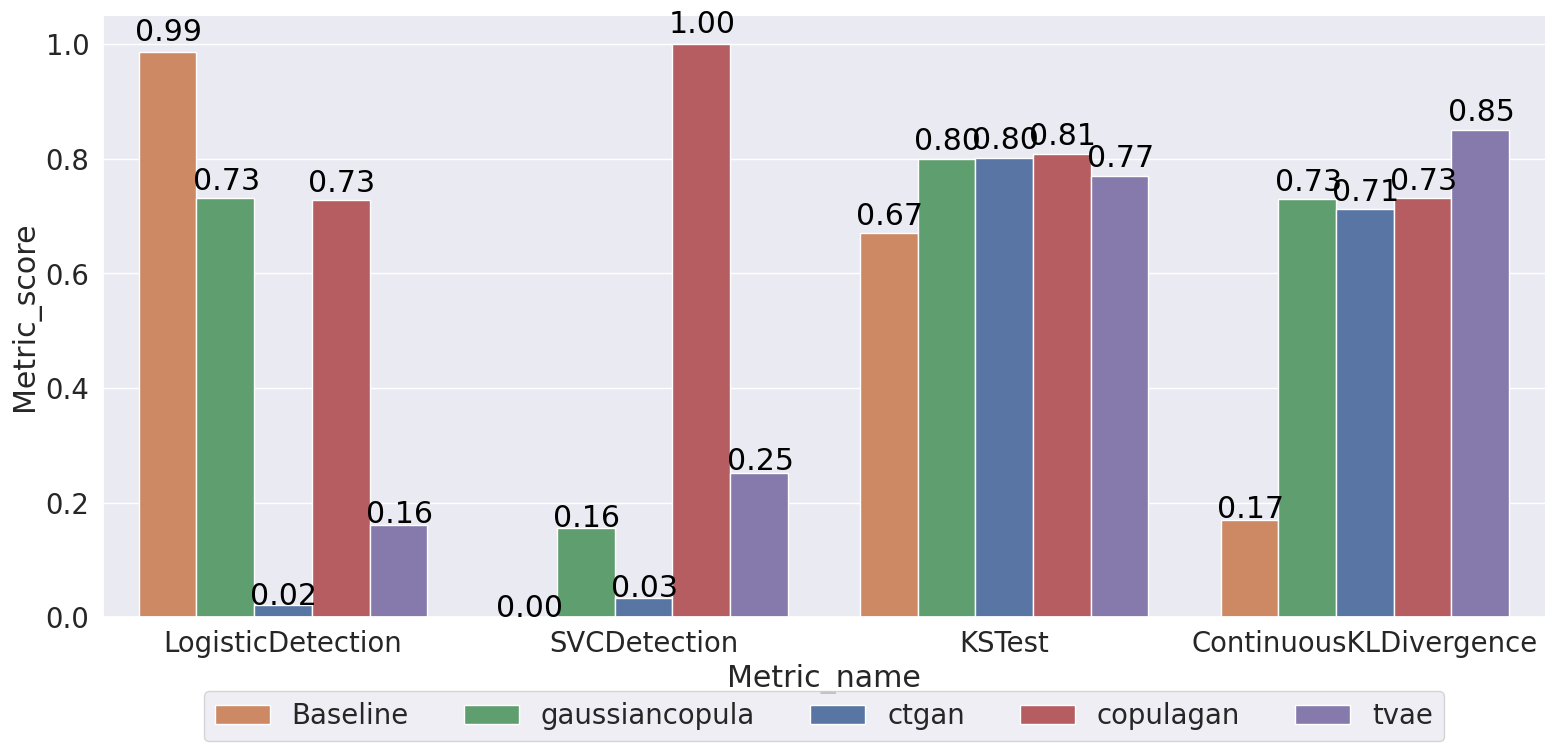

In [25]:
print(ml_time)

rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=1.8)  # crazy big
plot = sns.catplot(
    data=ml_result, x="Metric_name", y="Metric_score",
    hue="Model_name", kind="bar", aspect=2, height=8,
    palette=["C1", "C2", "C0", "C3", "C4"], legend=False
)
ax = plot.facet_axis(0,0)
hist_val = create_hist_values(ml_result)
for (p, val) in zip(ax.patches, hist_val):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.tight_layout()

# Netflix items generation quality

In [6]:
model_names = ['gaussiancopula', 'ctgan', 'copulagan', 'tvae']

nf_result = pd.DataFrame()
nf_time = {}
nf_gens = []

nf_result = pd.concat([nf_result, test_baseline(nf_items_df.drop('item_idx'))])

for model_name in model_names:
    g = SDVDataGenerator(
        label='synth_item',
        id_column_name='item_idx',
        model_name=model_name,
        parallelization_level=8,
        device_name='cpu'
    )

    t, g, r = test_gen(g, nf_items_df.drop('item_idx'))
    nf_result = pd.concat([nf_result, r])
    nf_time[g._model_name] = t
    nf_gens.append(g)

Training gaussiancopula generator
Evaluating gaussiancopula generator


22/11/07 08:59:42 WARN DAGScheduler: Broadcasting large task binary with size 1024.3 KiB
22/11/07 08:59:44 WARN DAGScheduler: Broadcasting large task binary with size 1025.9 KiB


Training ctgan generator
Evaluating ctgan generator


Training copulagan generator
Evaluating copulagan generator


Training tvae generator
Evaluating tvae generator


{'gaussiancopula': 10.355485200881958, 'ctgan': 3608.2248549461365, 'copulagan': 3585.273941040039, 'tvae': 1595.131076335907}


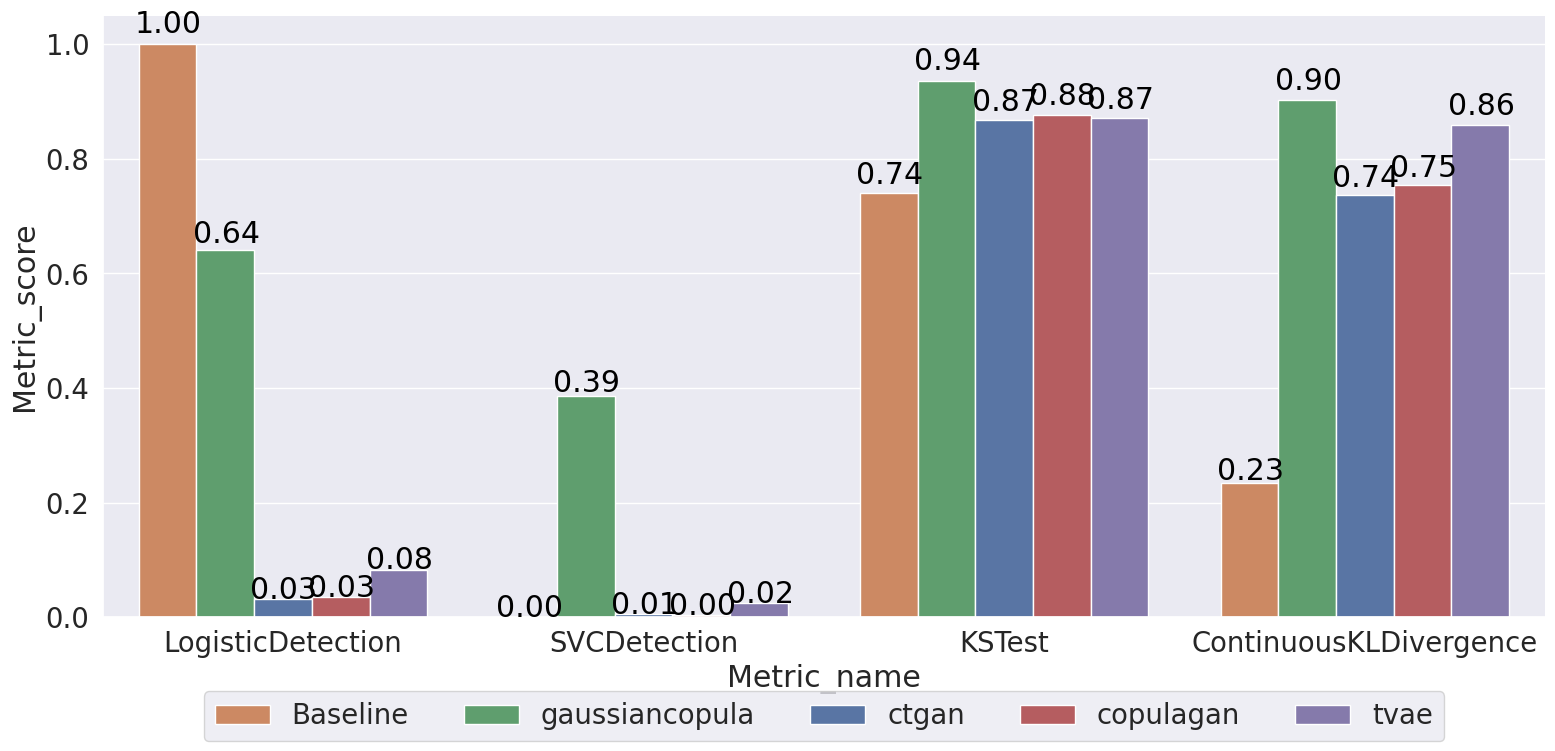

In [32]:
print(nf_time)

rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=1.8)  # crazy big
plot = sns.catplot(
    data=nf_result, x="Metric_name", y="Metric_score",
    hue="Model_name", kind="bar", aspect=2, height=8,
    palette=["C1", "C2", "C0", "C3", "C4"], legend=False
)
ax = plot.facet_axis(0,0)
hist_val = create_hist_values(nf_result)
for (p, val) in zip(ax.patches, hist_val):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.tight_layout()

# Amazon items generation quality

In [41]:
model_names = ['gaussiancopula', 'ctgan', 'copulagan', 'tvae']

am_result = pd.DataFrame()
am_time = {}
am_gens = []

am_result = pd.concat([am_result, test_baseline(am_items_df.sample(0.1).drop('item_idx'))])

for model_name in model_names:
    g = SDVDataGenerator(
        label='synth_item',
        id_column_name='item_idx',
        model_name=model_name,
        parallelization_level=8,
        device_name='cpu'
    )

    t, g, r = test_gen(g, am_items_df.sample(0.1).drop('item_idx'))
    am_result = pd.concat([am_result, r])
    am_time[g._model_name] = t
    am_gens.append(g)

Training gaussiancopula generator


Evaluating gaussiancopula generator


22/11/07 12:20:24 WARN DAGScheduler: Broadcasting large task binary with size 1024.3 KiB
22/11/07 12:20:32 WARN DAGScheduler: Broadcasting large task binary with size 1025.9 KiB


Training ctgan generator


Evaluating ctgan generator


Training copulagan generator


Evaluating copulagan generator


Training tvae generator


Evaluating tvae generator


{'gaussiancopula': 8.660092115402222, 'ctgan': 3919.4720420837402, 'copulagan': 3528.236780643463, 'tvae': 1616.6328485012054}


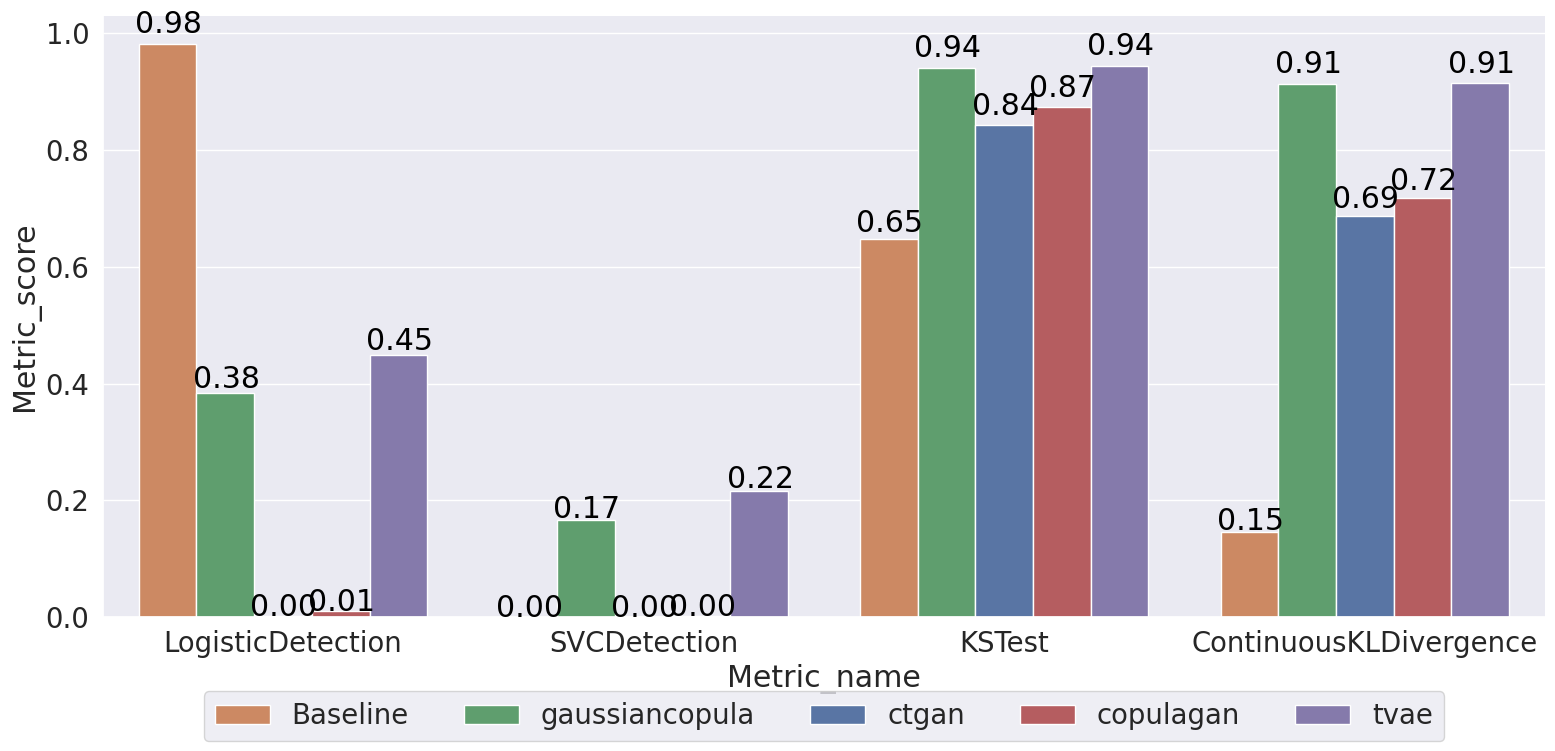

In [42]:
print(am_time)

rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=1.8)  # crazy big
plot = sns.catplot(
    data=am_result, x="Metric_name", y="Metric_score",
    hue="Model_name", kind="bar", aspect=2, height=8,
    palette=["C1", "C2", "C0", "C3", "C4"], legend=False
)
ax = plot.facet_axis(0,0)
hist_val = create_hist_values(am_result)
for (p, val) in zip(ax.patches, hist_val):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.tight_layout()